In [9]:
import arfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from sklearn.base import clone
rng = np.random.RandomState(seed=42)

from NFLUtils import NFLUtils
nfl_utils = NFLUtils()

In [10]:
# Columns to include 
cont_cols = [col for col in nfl_utils.cont_cols if col not in nfl_utils.drop_cols]

### Import dataset & select relevant columns
Using CombinedSlidingWindow4, grab only the columns that will be passed into the prediction algorithms

In [11]:
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)
df.info()
y = df['H_Won']
df = df[cont_cols]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464 entries, 0 to 5463
Data columns (total 70 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5464 non-null   int64  
 1   Season                   5464 non-null   int64  
 2   Date                     5464 non-null   object 
 3   Home_Team                5464 non-null   object 
 4   Visitor_Team             5464 non-null   object 
 5   H_halftime_odds          5464 non-null   float64
 6   V_halftime_odds          5464 non-null   float64
 7   H_start_odds             5464 non-null   float64
 8   V_start_odds             5464 non-null   float64
 9   H_Won                    5464 non-null   float64
 10  D_First_Downs            5464 non-null   float64
 11  D_Rush                   5464 non-null   float64
 12  D_Yds                    5464 non-null   float64
 13  D_TDs                    5464 non-null   float64
 14  D_Cmp                   

### Perform exploratory data analysis via ydata-profiling
Use this to explore the dataset & develop hypothesis that can be later tested.

In [12]:
profile = ProfileReport(df, title="Profiling Report")

# Configuration
profile.config.vars.num.skewness_threshold = 1

# Save profile to file

In [13]:
# profile.to_widgets()
# profile.to_file("EdaReportTwo.html")

# ARFS and feature selection
[you'll need at least python 3.9 for this](https://github.com/ThomasBury/arfs/issues/29) 

In [14]:
X = df
print(X.shape)
print(y.shape)

(5464, 53)
(5464,)


In [15]:
import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data
from sklearn.pipeline import Pipeline


/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/arfs/feature_selection/allrelevant.py:1578: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['D_Rush' 'D_passing_att' 'D_scoring_xpa' 'D_scoring_xpp' 'D_pythagorean'
 'D_start_odds']
The agnostic ranking: [1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
The naive ranking: ['D_start_odds', 'D_pythagorean', 'D_scoring_xpa', 'D_scoring_xpp', 'D_passing_att', 'D_Rush', 'D_fumbles_fr', 'D_punting_pnt', 'kick_punt_umap_dim_2', 'D_First_Downs', 'D_Yds', 'D_passing_sk', 'D_passing_cmp', 'D_Sacked_Yards', 'kick_punt_umap_dim_1', 'D_passing_lng', 'D_rushing_lng', 'D_def_interceptions_int', 'D_tackles_ast', 'D_Fumbles', 'D_scoring_fgp', 'D_sk', 'D_passing_int', 'D_Cmp', 'D_TDs', 'D_rushing_td', 'D_scoring_fga', 'D_Total_Yards', 'D_Turnovers', 'D_fumbles_td', 'D_Sacked', 'D_def_interceptions_td', 'D_def_interceptions_yds', 'D_INT', 'D_tackles_comb', 'D_Lost', 'D_rushing_att', 'D_receiving_lng', 'D_rushing_yds', 'D_Yd', 'D_Time_of_Possession', 'D_passing_td', 'D_Fourth_Down_Conv', 'D_punting_avg', 'D_fumble

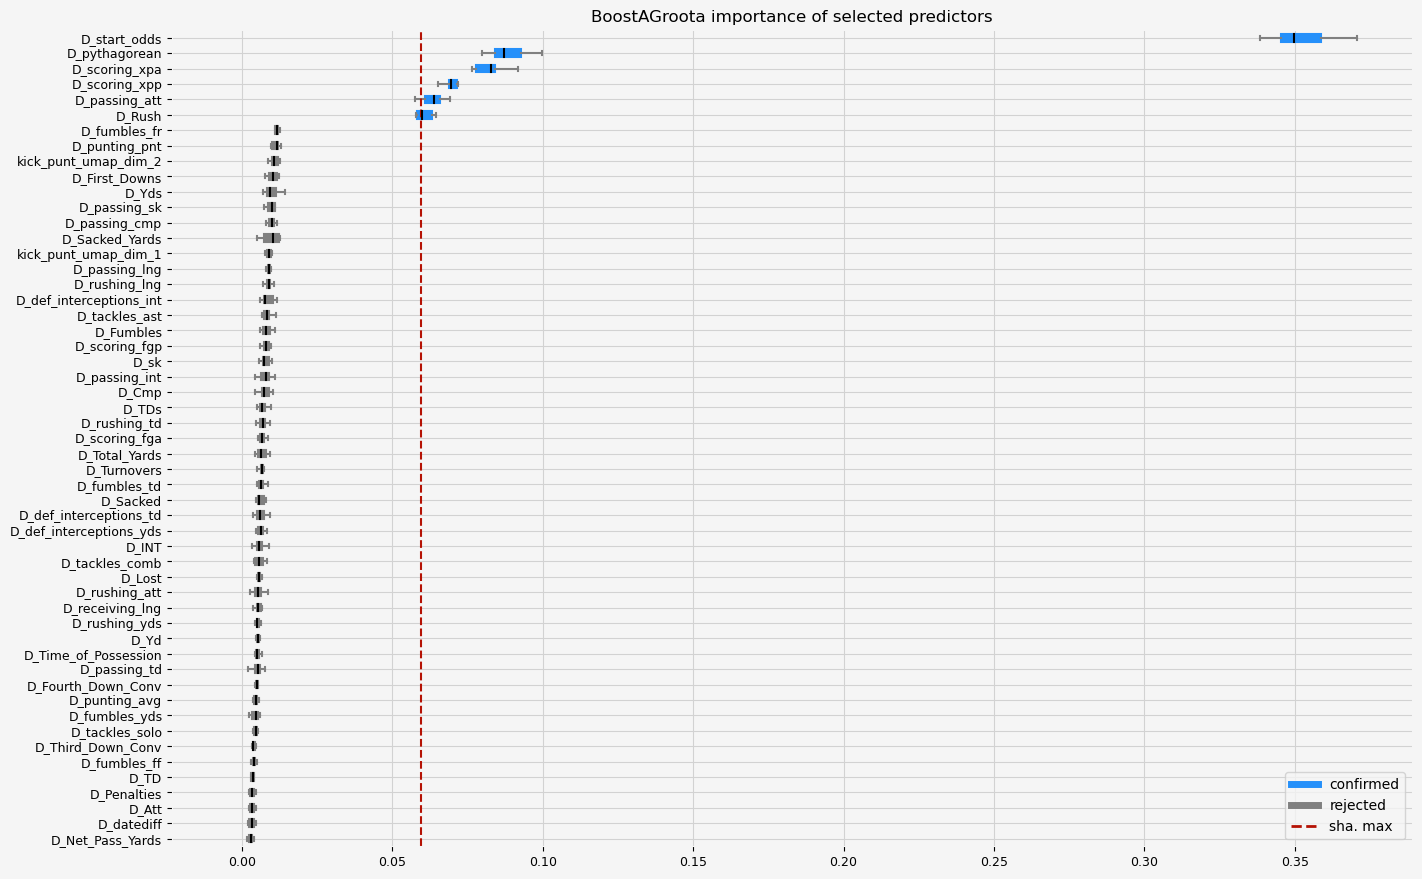

In [16]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# Leshy

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	48
All relevant predictors selected in 00:00:01.00
The selected features: ['D_pythagorean' 'D_start_odds']
The agnostic ranking: [50 29 10  5 44 36 14 40 36 20 14 10 40  6  2 19 20 18 46  4 23 33 17 49
 40 40 40 31 26 46  7 48 33 29 45 29  2 40 12 14 22 26 36  7 10  3 23 14
 26  2 33  1  1]
The naive ranking: ['D_start_odds', 'D_pythagorean', 'D_Fumbles', 'D_scoring_xpa', 'D_fumbles_fr', 'D_punting_pnt', 'D_Yds', 'kick_punt_umap_dim_2', 'D_Fourth_Down_Conv', 'kick_punt_umap_dim_1', 'D_rushing_td', 'D_passing_cmp', 'D_Total_Yards', 'D_Rush', 'D_Sacked_Yards', 'D_Att', 'D_sk', 'D_scoring_fga', 'D_tackles_ast', 'D_Penalties', 'D_fumbles_yds', 'D_tackles_comb', 'D_Lost', 'D_Sacked', 'D_Turnovers', 'D_punting_avg', 'D_INT', 'D_scoring_xpp', 'D_def_interceptions_td', 'D_passing_td', 'D_First_Downs', 'D_Time_of_Possession', 'D_passing_att', 'D_rushing_att', 'D_receiving_lng', 'D_tackles_

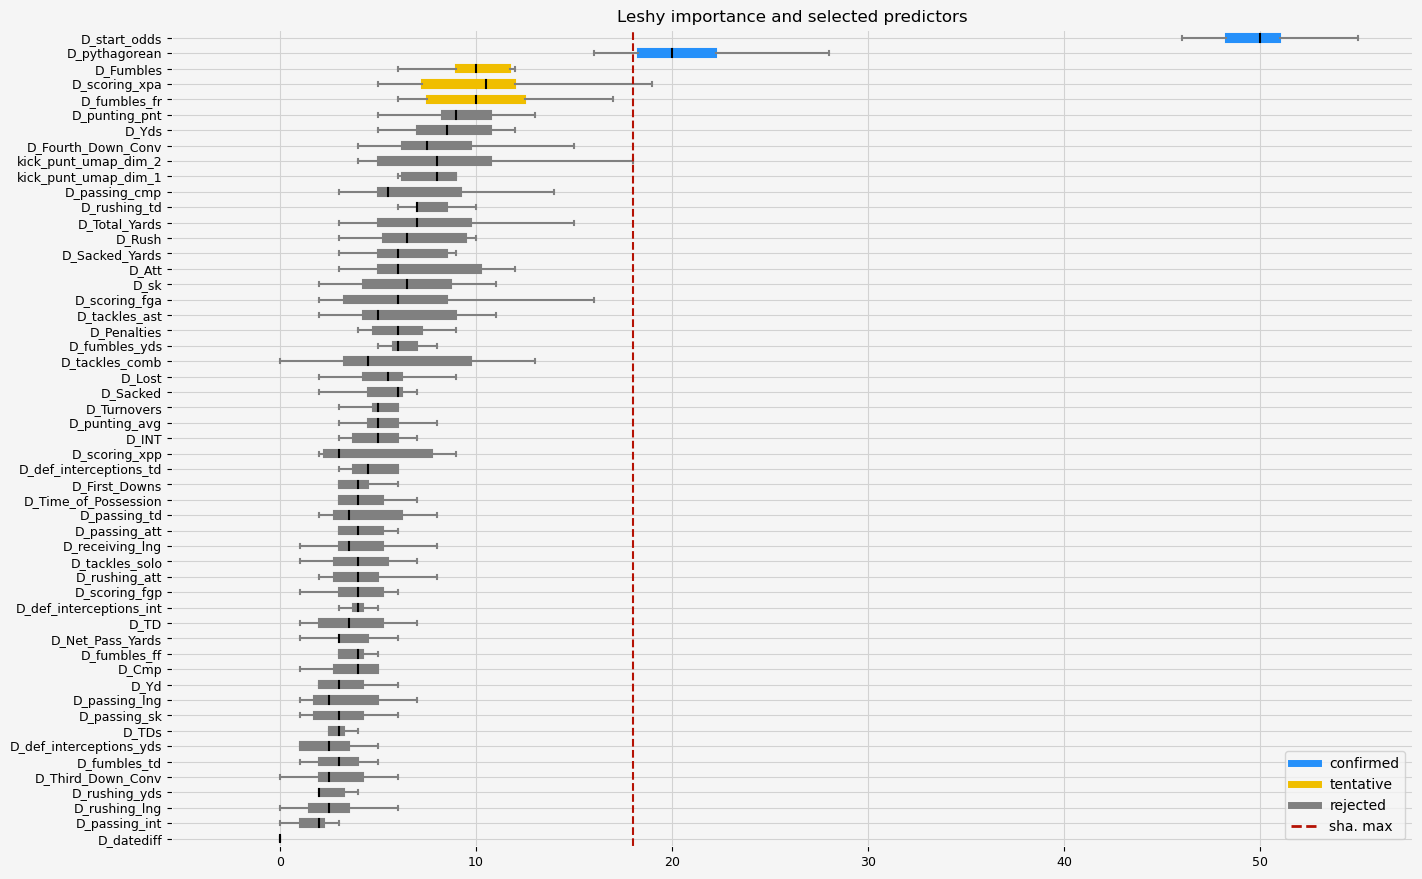

In [17]:
model = LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## Columns that will be dropped are going to be stored in NFLUtils.drop_cols


### Removed based off of correlation matrix results
- D_passing_yds
- D_receiving_yds
- D_def_interceptions_lng
- D_receiving_td

### Removed after composing meta-features from pairs of similar columns
- D_scoring_fgm
- D_scoring_xpm
- D_punting_yds

### Removed after applying UMAP
- D_kick_returns_lng
- D_kick_returns_rt
- D_kick_returns_td
- D_kick_returns_yds
- D_punt_returns_lng
- D_punt_returns_ret
- D_punt_returns_td
- D_punt_returns_yds

### Created temporarily for UMAP
- kick_punt_returns_lng
- kick_punt_returns_rt
- kick_punt_returns_td
- kick_punt_returns_yds

### Removed from feature importance using Leshy & BoostAGroota
- D_datediff
- D_Third_Down_Conv
- D_fumbles_ff
- D_Net_Pass_Yards
- D_TD